In [2]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\Mohit Bhakuni\Downloads\Fraud.csv")
df

step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1              19384.72  M2044282225            0.00            0.00        0   
2                  0.00   C553264065            0.00            0.00        1   
3                  0.00    C38997010        21182.00            0.00        1   
4              29885.86  M1230701703            0.00            0.00        0   
...                 ...          ...             ...             ...      ...   
6362615            0.00   C776919290            0.00       339682.13        1   
6362616            0.00  C1881841831            0.00            0.00        1   
6362617            0.00  C1365125890        68488.84      6379898.11        1   
6362618            0.00  C2080388513            0.00            0.00        1   
6362619            0.00   C873221189      6510099.11      7360101.63        1   

         isFlaggedFraud  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
6362615               0  
6362616               0  
6362617               0  
6362618               0  
6362619               0  

[6362620 rows x 11 columns]

### Column Descriptions
1. **step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

3. **amount:** amount of the transaction in local currency.

4. **nameOrig:** customer who started the transaction

5. **oldbalanceOrg:** initial balance before the transaction

6. **newbalanceOrig:** new balance after the transaction

7. **nameDest:** customer who is the recipient of the transaction

8. **oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. **newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. **isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. **isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [7]:
# Now, let's check for data type and missing values across the entire dataset:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [27]:
# Automatic Data Analysis Report

import pandas_profiling
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Insights:**
    
    1. nameOrig has a high cardinality(distinct values): 6353307 distinct values
    2. nameDest has a high cardinality: 2722362 distinct values
    3. amount is highly overall correlated with oldbalanceDest and newbalanceDest
    4. oldbalanceOrg is highly overall correlated with amount and newbalanceOrig
    5. newbalanceOrig is highly overall correlated with amount and oldbalanceOrg
    6. isFraud is highly imbalanced (98.6%)
    7. isFlaggedFraud is highly imbalanced (> 99.9%)
    8. amount is highly skewed (γ1 = 30.99394948)
    9. nameOrig is uniformly distributed
    10. oldbalanceOrg has 2102449 (33.0%) zeros
    11. newbalanceOrig has 3609566 (56.7%) zeros 
    12. oldbalanceDest has 2704388 (42.5%) zeros
    13. newbalanceDest has 2439433 (38.3%) zeros
    14. No Missing Value
    15. No Duplicates

In [17]:
filtered_data = df[df["nameDest"].str.startswith("M")]
filtered_data

step     type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0           1  PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1           1  PAYMENT   1864.28  C1666544295        21249.0        19384.72   
4           1  PAYMENT  11668.14  C2048537720        41554.0        29885.86   
5           1  PAYMENT   7817.71    C90045638        53860.0        46042.29   
6           1  PAYMENT   7107.77   C154988899       183195.0       176087.23   
...       ...      ...       ...          ...            ...             ...   
6362312   718  PAYMENT   8178.01  C1213413071        11742.0         3563.99   
6362314   718  PAYMENT  17841.23  C1045048098        10182.0            0.00   
6362316   718  PAYMENT   1022.91  C1203084509           12.0            0.00   
6362318   718  PAYMENT   4109.57   C673558958         5521.0         1411.43   
6362319   718  PAYMENT   8634.29   C642813806       518802.0       510167.71   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0        M1979787155             0.0             0.0        0               0  
1        M2044282225             0.0             0.0        0               0  
4        M1230701703             0.0             0.0        0               0  
5         M573487274             0.0             0.0        0               0  
6         M408069119             0.0             0.0        0               0  
...              ...             ...             ...      ...             ...  
6362312  M1112540487             0.0             0.0        0               0  
6362314  M1878955882             0.0             0.0        0               0  
6362316   M675916850             0.0             0.0        0               0  
6362318  M1126011651             0.0             0.0        0               0  
6362319   M747723689             0.0             0.0        0               0  

[2151495 rows x 11 columns]

In [19]:
filtered_data["oldbalanceDest"].nunique()   # There is no data for nameDest( Name of Destination customer) of Merchants starting with M thus only contains 0

1

In [20]:
legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_per = (legit / (fraud + legit)) * 100
fraud_per = (fraud / (fraud + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(legit_per))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_per))

Number of Legit transactions:  6354407
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


These results prove that this is a highly unbalanced data as Percentage of Legit transactions= 99.87 % and Percentage of Fraud transactions= 0.13 %. SO DECISION TREES AND RANDOM FORESTS ARE GOOD METHODS FOR IMBALANCED DATA.

In [3]:
new_df = df.copy()
new_df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

<AxesSubplot: >

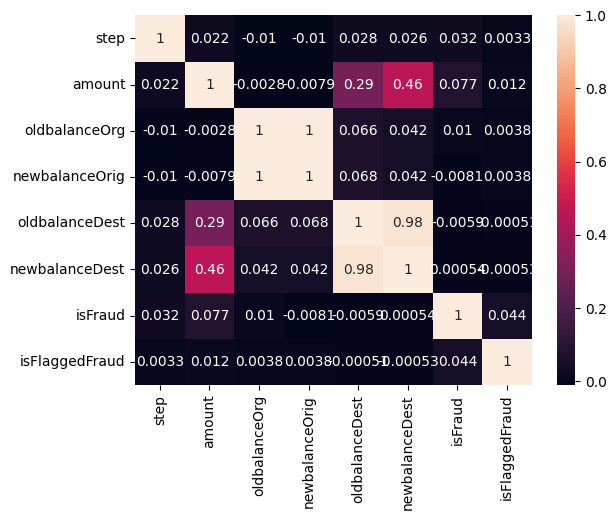

In [5]:
sns.heatmap(data = new_df.corr(numeric_only = True), annot= True)

### Description Statistics

In [4]:
num_attributes = new_df.select_dtypes(exclude='object')
cat_attributes = new_df.select_dtypes(include='object')

#### i) Numerical Attributes

In [8]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

count          mean           std  min       25%  \
step            6362620.0  2.433972e+02  1.423320e+02  1.0    156.00   
amount          6362620.0  1.798619e+05  6.038582e+05  0.0  13389.57   
oldbalanceOrg   6362620.0  8.338831e+05  2.888243e+06  0.0      0.00   
newbalanceOrig  6362620.0  8.551137e+05  2.924049e+06  0.0      0.00   
oldbalanceDest  6362620.0  1.100702e+06  3.399180e+06  0.0      0.00   
newbalanceDest  6362620.0  1.224996e+06  3.674129e+06  0.0      0.00   
isFraud         6362620.0  1.290820e-03  3.590480e-02  0.0      0.00   
isFlaggedFraud  6362620.0  2.514687e-06  1.585775e-03  0.0      0.00   

                       50%           75%           max         range  \
step               239.000  3.350000e+02  7.430000e+02  7.420000e+02   
amount           74871.940  2.087215e+05  9.244552e+07  9.244552e+07   
oldbalanceOrg    14208.000  1.073152e+05  5.958504e+07  5.958504e+07   
newbalanceOrig       0.000  1.442584e+05  4.958504e+07  4.958504e+07   
oldbalanceDest  132705.665  9.430367e+05  3.560159e+08  3.560159e+08   
newbalanceDest  214661.440  1.111909e+06  3.561793e+08  3.561793e+08   
isFraud              0.000  0.000000e+00  1.000000e+00  1.000000e+00   
isFlaggedFraud       0.000  0.000000e+00  1.000000e+00  1.000000e+00   

                variation coefficient        skew       kurtosis  
step                         0.584772    0.375177       0.329071  
amount                       3.357344   30.993949    1797.956705  
oldbalanceOrg                3.463606    5.249136      32.964879  
newbalanceOrig               3.419485    5.176884      32.066985  
oldbalanceDest               3.088194   19.921758     948.674125  
newbalanceDest               2.999298   19.352302     862.156508  
isFraud                     27.815485   27.779538     769.702982  
isFlaggedFraud             630.605116  630.603629  397659.062500

Insights:

- All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.
- The step variable starts from 1 hour to 742 hour (30 days).
- All variables are rightly skewed.
- There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

#### ii) Categorical Attributes


In [9]:
cat_attributes.describe()

type     nameOrig     nameDest
count    6362620      6362620      6362620
unique         5      6353307      2722362
top     CASH_OUT  C1902386530  C1286084959
freq     2237500            3          113

In [10]:
new_df["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [11]:
new_df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Insights:

- The majority type is cash_out with 2237500.
- There's a lot of variability in nameOrig and nameDest so cannot use one hot encoding.
- There's less nameDest than nameOrig. There's more users sending than receiving.

## Feature Engineering

In [4]:
df1 = df.copy()
df1.head(1)

step     type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  PAYMENT  9839.64  C1231006815       170136.0       160296.36   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0

In [5]:
# step
df1['step_days'] = df1['step'].apply(lambda i: i/24)
df1['step_weeks'] = df1['step'].apply(lambda i: i/(24*7))

# difference between initial balance of origin before the transaction and new balance of origin after the transaction
df1['diff_new_old_origin'] = df1['newbalanceOrig'] - df1['oldbalanceOrg']

# difference between initial balance of recipient before the transaction and new balance of recipient after the transaction.
df1['diff_new_old_destiny'] = df1['newbalanceDest'] - df1['oldbalanceDest']

# name orig and name dest
df1['nameOrig'] = df1['nameOrig'].apply(lambda i: i[0])
df1['nameDest'] = df1['nameDest'].apply(lambda i: i[0])

In [7]:
df1.head(5)

step      type    amount nameOrig  oldbalanceOrg  newbalanceOrig nameDest  \
0     1   PAYMENT   9839.64        C       170136.0       160296.36        M   
1     1   PAYMENT   1864.28        C        21249.0        19384.72        M   
2     1  TRANSFER    181.00        C          181.0            0.00        C   
3     1  CASH_OUT    181.00        C          181.0            0.00        C   
4     1   PAYMENT  11668.14        C        41554.0        29885.86        M   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  step_days  \
0             0.0             0.0        0               0   0.041667   
1             0.0             0.0        0               0   0.041667   
2             0.0             0.0        1               0   0.041667   
3         21182.0             0.0        1               0   0.041667   
4             0.0             0.0        0               0   0.041667   

   step_weeks  diff_new_old_origin  diff_new_old_destiny  
0    0.005952             -9839.64                   0.0  
1    0.005952             -1864.28                   0.0  
2    0.005952              -181.00                   0.0  
3    0.005952              -181.00              -21182.0  
4    0.005952            -11668.14                   0.0

## Exploratory Data Analysis (EDA)

In [6]:
df2 = df1.copy()

### 1. Univariate Analysis

#### Target Variable - 
We already know that this is a highly unbalanced data as Percentage of Legit transactions= 99.87 % and Percentage of Fraud transactions= 0.13 %.

####  Numerical Features

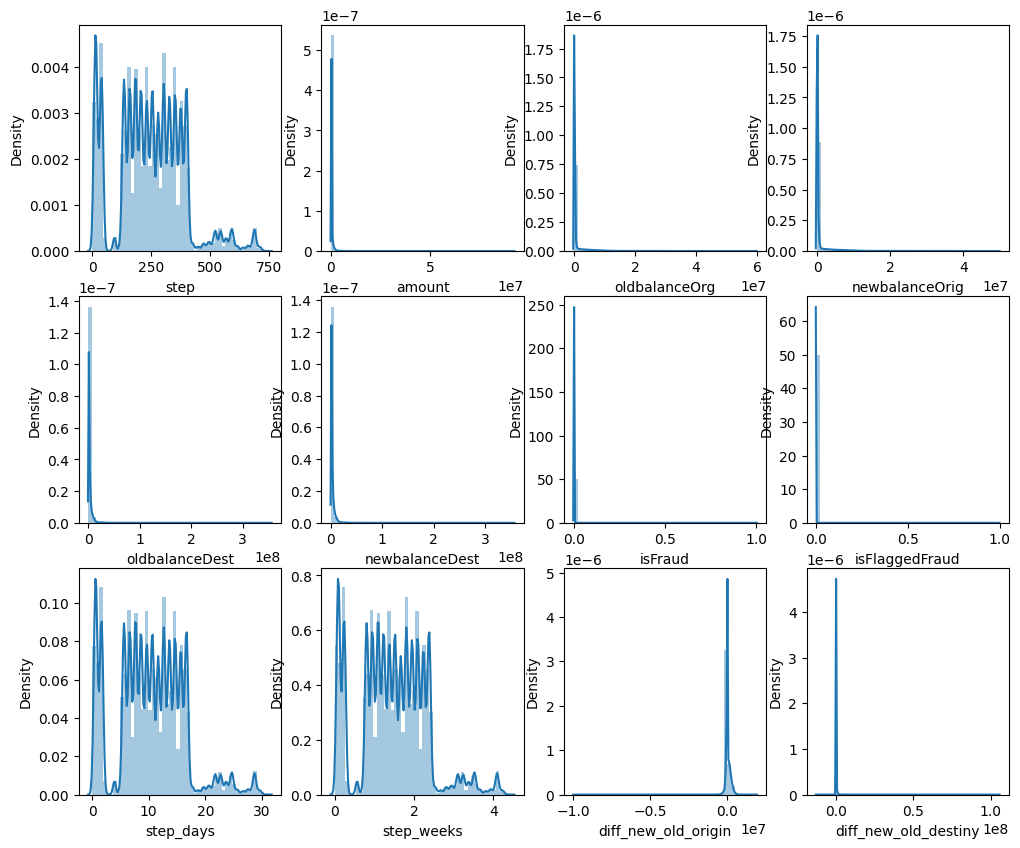

In [14]:
plt.figure(figsize = (12,10))
num_attributes = df2.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3,4, j)
    sns.distplot(num_attributes[column])
    
    j += 1

#### Categorical Variables

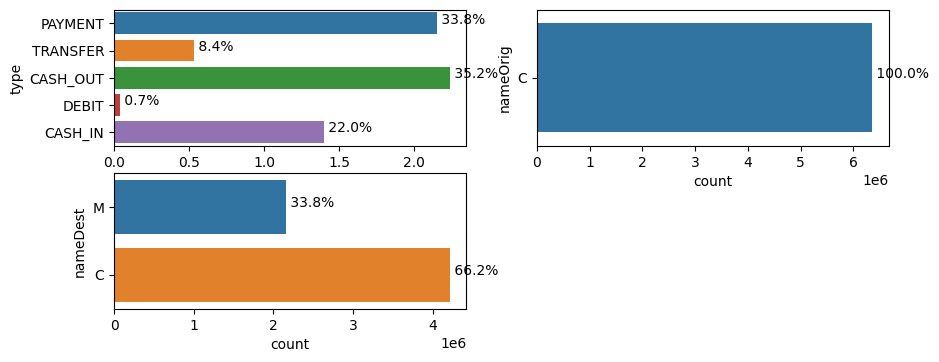

In [16]:
plt.figure(figsize = (10,6))
cat_attributes = df2.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

In [18]:
df2["nameOrig"].value_counts()  # All nameOrig starts with C ( ie customers )

nameOrig
C    6362620
Name: count, dtype: int64

In [19]:
df2["nameDest"].value_counts() 

nameDest
C    4211125
M    2151495
Name: count, dtype: int64

### 2. Bivariate Analysis

#### i) "isFraud vs nameOrig"   and   "isFraud vs nameDest"

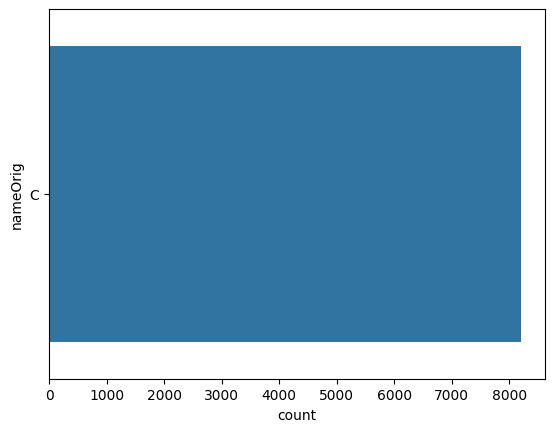

In [22]:
fraud = df2[df2['isFraud'] == True]
sns.countplot(y='nameOrig', data= fraud)

In [26]:
df2['nameOrig'][df2['isFraud'] == True].value_counts()

nameOrig
C    8213
Name: count, dtype: int64

<AxesSubplot: xlabel='count', ylabel='nameDest'>

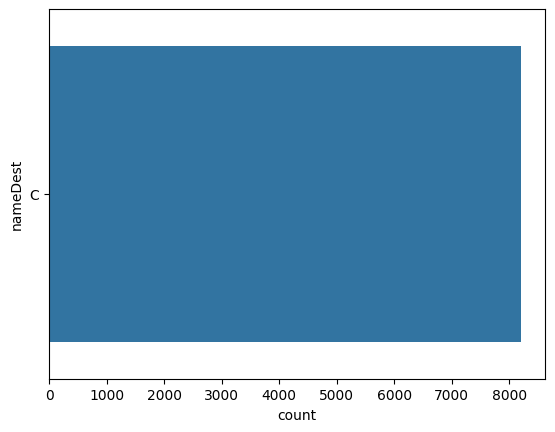

In [24]:
sns.countplot(y='nameDest', data= fraud)

In [27]:
df2['nameDest'][df2['isFraud'] == True].value_counts()     

nameDest
C    8213
Name: count, dtype: int64

All frauds took place between customer to customer (No merchant account is involved )

#### ii) "amount VS isFraud"

<AxesSubplot: xlabel='isFraud', ylabel='amount'>

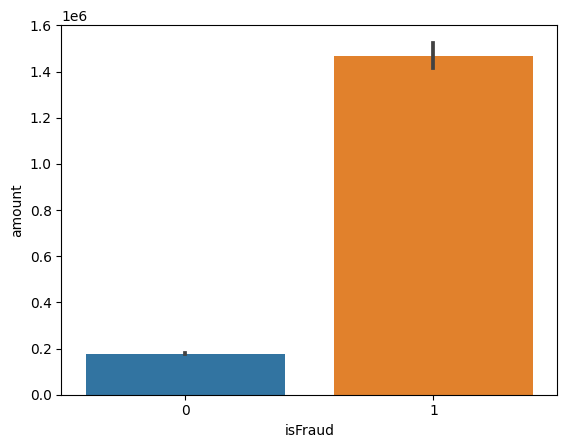

In [41]:
sns.barplot(y='amount', x='isFraud', data= df2)

In [37]:
fraud = df2[df2['isFraud'] == True]       # Maximum Amount of transaction when fraud occurs is 1,00,00,000
fraud['amount'].max()

10000000.0

In [38]:
df2['amount'].max()                   # Maximum Amount of transaction overall is 9,24,45,516

92445516.64

In [44]:
fraud['amount'].sum()                     # Total amount of transactions when fraud occurs is 12,05,64,15,427

12056415427.839998

In [45]:
df2['amount'].sum()                   # Total amount of transactions overall is 11,44,39,29,44,759

1144392944759.77

In [47]:
( 12056415427.839998 / 1144392944759.77 )*100

1.0535206008606486

Maximum Amount of transaction when fraud occurs is 1,00,00,000, however Maximum Amount of transaction overall is 9,24,45,516.
Only 1% of total amount of transaction were fraud transaction amount.

#### iii) "isFraud VS type"

In [49]:
fraud['type'].value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

#### iv) "type VS amount"

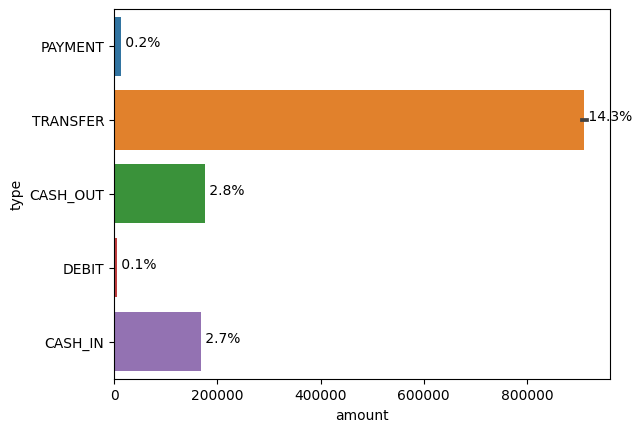

In [51]:
ax = sns.barplot(y='type', x='amount', data=df2);

total = df2['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

The majority transactions occours in trasnfer-type, however transactions greater than 100000 occur in cash-out and cash-in too.

### 3. Multivariaty Analysis

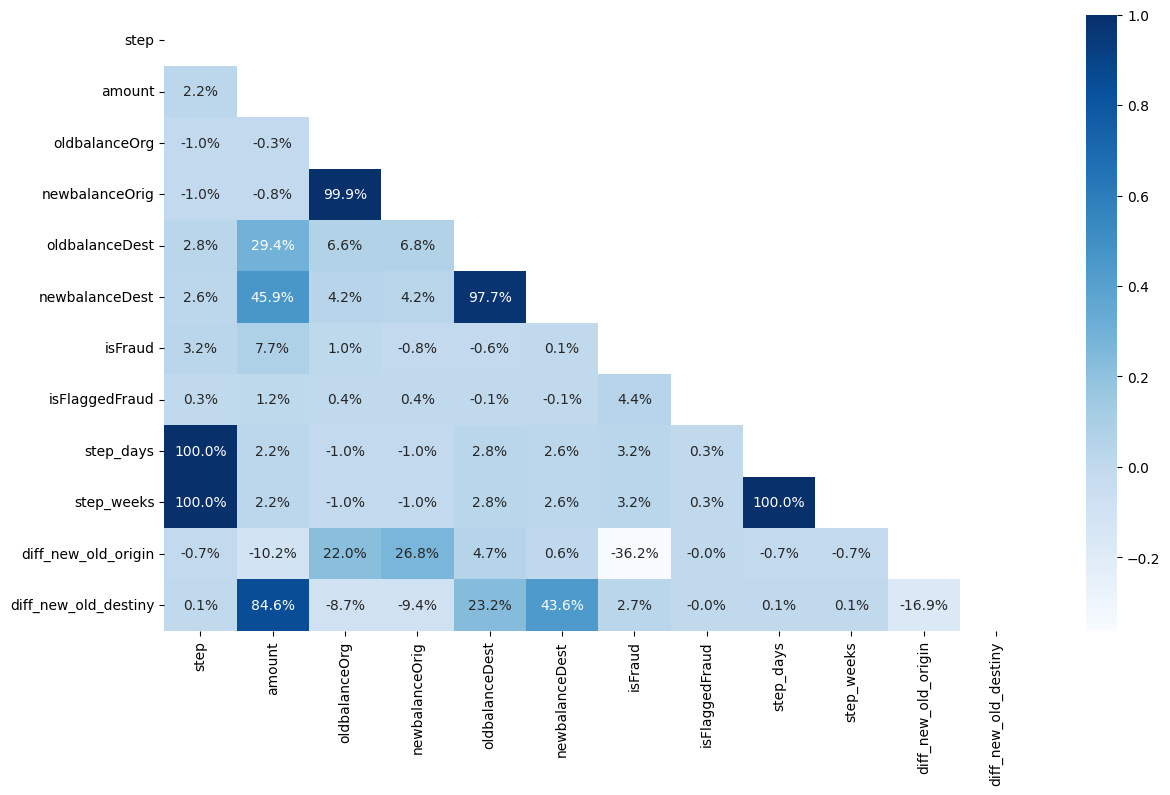

In [61]:
plt.figure(figsize =(14, 8))
mask = np.triu(np.ones_like(df2.corr(numeric_only = True)))
sns.heatmap(df2.corr(numeric_only = True), cmap ="Blues", annot=True, fmt = ".1%", mask = mask)
plt.show()

## Feature Selection

#### Data Preparation

In [7]:
df3 = df2.copy()

In [8]:
df3.head(1)

step     type   amount nameOrig  oldbalanceOrg  newbalanceOrig nameDest  \
0     1  PAYMENT  9839.64        C       170136.0       160296.36        M   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  step_days  \
0             0.0             0.0        0               0   0.041667   

   step_weeks  diff_new_old_origin  diff_new_old_destiny  
0    0.005952             -9839.64                   0.0

In [9]:
df3.drop(columns=['isFlaggedFraud', 'nameOrig', 'nameDest', 'step_weeks', 'step_days'], axis=1, inplace = True)

In [10]:
df3.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'diff_new_old_origin',
       'diff_new_old_destiny'],
      dtype='object')

#### One Hot Encoding

In [11]:
from category_encoders import OneHotEncoder

encoder = OneHotEncoder(cols=['type'], use_cat_names=True)
df3 = encoder.fit_transform(df3)
df3.head(5)

step  type_PAYMENT  type_TRANSFER  type_CASH_OUT  type_DEBIT  type_CASH_IN  \
0     1             1              0              0           0             0   
1     1             1              0              0           0             0   
2     1             0              1              0           0             0   
3     1             0              0              1           0             0   
4     1             1              0              0           0             0   

     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0   9839.64       170136.0       160296.36             0.0             0.0   
1   1864.28        21249.0        19384.72             0.0             0.0   
2    181.00          181.0            0.00             0.0             0.0   
3    181.00          181.0            0.00         21182.0             0.0   
4  11668.14        41554.0        29885.86             0.0             0.0   

   isFraud  diff_new_old_origin  diff_new_old_destiny  
0        0             -9839.64                   0.0  
1        0             -1864.28                   0.0  
2        1              -181.00                   0.0  
3        1              -181.00              -21182.0  
4        0            -11668.14                   0.0

#### Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler

num_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
               'diff_new_old_origin', 'diff_new_old_destiny']
scaler = MinMaxScaler()
df3[num_columns] = scaler.fit_transform(df3[num_columns])
df3.head(5)

step  type_PAYMENT  type_TRANSFER  type_CASH_OUT  type_DEBIT  type_CASH_IN  \
0     1             1              0              0           0             0   
1     1             1              0              0           0             0   
2     1             0              1              0           0             0   
3     1             0              0              1           0             0   
4     1             1              0              0           0             0   

     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0  0.000106       0.002855        0.003233        0.000000             0.0   
1  0.000020       0.000357        0.000391        0.000000             0.0   
2  0.000002       0.000003        0.000000        0.000000             0.0   
3  0.000002       0.000003        0.000000        0.000059             0.0   
4  0.000126       0.000697        0.000603        0.000000             0.0   

   isFraud  diff_new_old_origin  diff_new_old_destiny  
0        0             0.838434              0.109987  
1        0             0.839103              0.109987  
2        1             0.839244              0.109987  
3        1             0.839244              0.109809  
4        0             0.838280              0.109987

#### Multicolinearity

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(df3)

variables       VIF
0                   step  1.003445
1           type_PAYMENT       inf
2          type_TRANSFER       inf
3          type_CASH_OUT       inf
4             type_DEBIT       inf
5           type_CASH_IN       inf
6                 amount  4.073803
7          oldbalanceOrg       inf
8         newbalanceOrig       inf
9         oldbalanceDest       inf
10        newbalanceDest       inf
11               isFraud  1.223435
12   diff_new_old_origin       inf
13  diff_new_old_destiny       inf

In [14]:
df4 = df3.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
calc_vif(df4)

variables          VIF
0                  step     1.002571
1          type_PAYMENT  3116.052988
2         type_TRANSFER   770.462852
3         type_CASH_OUT  3231.288282
4            type_DEBIT    61.049486
5          type_CASH_IN  2079.723967
6                amount     3.984381
7               isFraud     1.223207
8   diff_new_old_origin     1.719308
9  diff_new_old_destiny     3.864783

In [15]:
df4 = df4.drop(['type_CASH_OUT'],axis=1)
calc_vif(df4)

variables         VIF
0                  step    3.931789
1          type_PAYMENT    1.995369
2         type_TRANSFER    1.385264
3            type_DEBIT    1.019228
4          type_CASH_IN    1.995942
5                amount    4.025700
6               isFraud    1.015447
7   diff_new_old_origin  877.501075
8  diff_new_old_destiny  882.969077

In [16]:
df4 = df4.drop(['diff_new_old_destiny'],axis=1)
calc_vif(df4)

variables       VIF
0                 step  3.929736
1         type_PAYMENT  1.994323
2        type_TRANSFER  1.384443
3           type_DEBIT  1.019228
4         type_CASH_IN  1.650465
5               amount  1.284020
6              isFraud  1.009653
7  diff_new_old_origin  5.836177

## MODEL BUILDING

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#### TRAIN-TEST SPLIT

In [18]:
X = df4.drop(["isFraud"], axis= 1)
Y = df4["isFraud"]

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 7)
Shape of X_test:  (1908786, 7)


#### MODEL TRAINIG

In [19]:
# DECISION TREE

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

In [23]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

#### EVALUATION

In [24]:
# Print scores of our classifiers

print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)

Decision Tree Score:  99.89794560521715
Random Forest Score:  99.92665495241478


In [25]:
# key terms of Confusion Matrix - DT

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("---------------------------------------------------------------------------------")

# key terms of Confusion Matrix - RF

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1457
False Positives: 970
True Negatives: 1905381
False Negatives: 978
---------------------------------------------------------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 1250
False Positives: 215
True Negatives: 1906136
False Negatives: 1185


TP(Decision Tree) ~ TP(Random Forest) so no competetion here.

FP(Decision Tree) >> FP(Random Forest) - Random Forest has an edge

TN(Decision Tree) < TN(Random Forest) - Random Forest is better here too

FN(Decision Tree) ~ FN(Random Forest)


Here Random Forest looks good.

In [26]:
# classification report - DT

classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")

# classification report - RF

classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.60      0.60      0.60      2435

    accuracy                           1.00   1908786
   macro avg       0.80      0.80      0.80   1908786
weighted avg       1.00      1.00      1.00   1908786

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.85      0.51      0.64      2435

    accuracy                           1.00   1908786
   macro avg       0.93      0.76      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786



With Such a good precision and hence F1-Score, Random Forest comes out to be better as expected.

## CONCLUSION

We have seen that Accuracy of both Random Forest and Decision Tree is equal, although teh precision of Random Forest is more. In a fraud detection model, Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off.If either of the 2 reasons are not fulfiiled we may catch the innocent and leave the culprit.
This is also one of the reason why Random Forest and Decision Tree are used unstead of other algorithms.


Also the reason I have chosen this model is because of highly unbalanced dataset (Legit: Fraud :: 99.87:0.13). Random forest makes multiple decision trees which makes it easier (although time taking) for model to understand the data in a simpler way since Decision Tree makes decisions in a boolean way.


Models like XGBoost, Bagging, ANN, and Logistic Regression may give good accuracy but they won't give good precision and recall values.

What are the key factors that predict fraudulent customer?

1. The source of request is secured or not ?
2. Is the name of organisation asking for money is legit or not ?
3. Transaction history of vendors.

What kind of prevention should be adopted while company update its infrastructure?

1. Use smart vertified apps only.
2. Browse through secured websites.
3. Use secured internet connections (USE VPN).
4. Keep your mobile and laptop security updated.
5. Don't respond to unsolicited calls/SMS(s/E-mails.
6. If you feel like you have been tricked or security compromised, contact your bank immidiately.

Assuming these actions have been implemented, how would you determine if they work?

1. Bank sending E-statements.
2. Customers keeping a check of their account activity.
3. Always keep a log of your payments.